### Building a Digit Recognizer Neural Network By Sochimazuru (MNIST)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

### Step 1: Load and Preprocess the Data
- We'll use pandas to load the CSV files and torchvision for data transformation.

In [8]:
# Load the training and test data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Separate labels from features
train_labels = train_df["label"].values
train_images = train_df.drop(columns=["label"]).values  # Remove label column

# Normalize pixel values to range [0,1]
train_images = train_images / 255.0
test_images = test_df.values / 255.0

# Convert to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_images = torch.tensor(test_images, dtype=torch.float32)

# Reshape to (batch_size, channels, height, width)
train_images = train_images.view(-1, 1, 28, 28)
test_images = test_images.view(-1, 1, 28, 28)

# Create dataset
full_dataset = TensorDataset(train_images, train_labels)

# Split into Training (80%) and Validation (20%)
train_size = int(0.8 * len(full_dataset))  
val_size = len(full_dataset) - train_size  
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)  # Validation set
test_loader = DataLoader(TensorDataset(test_images), batch_size=64, shuffle=False)  # For inference

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

#Explanations:
# i Loaded the dataset using pandas.
#Extracted labels (digits) and pixel values separately.
#Normalized pixel values from [0,255] to [0,1] for better learning.
#Converted the data to PyTorch tensors to work with a neural network.
#Reshaped images from flat (1D) arrays to 28×28 matrices.
#Added random_split() - Splits 80% for training, 20% for validation.
#Created val_loader for validation - This ensures validation loss can be calculated.
#Created test_loader for testing - Needed for making predictions later.
#Created a DataLoader for easier batch processing.

Training samples: 33600, Validation samples: 8400


### Step 2: Define the Neural Network
- Now, we build a simple convolutional neural network (CNN) to classify digits.

In [10]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # First conv layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Second conv layer
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer (10 classes)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 32 * 7 * 7)  # Flatten
        x = self.relu(self.fc1(x))  # Fully connected -> ReLU
        x = self.fc2(x)  # Output layer
        return x

# Initialize model
model = DigitClassifier()

#Explanations:
#Conv2d layers: Detect patterns in the images.
#MaxPool2d: Reduces image size for efficient learning.
#ReLU activation: Helps learn non-linear relationships.
#Fully connected layers: Convert features into digit predictions.
#Output layer (10 neurons): Each neuron represents a digit (0-9).

### Step 3: Train the Neural Network
- We use cross-entropy loss (good for classification) and Adam optimizer.

In [12]:
# Define early stopping class
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.0001):
        self.patience = patience  # Number of bad epochs allowed before stopping
        self.min_delta = min_delta  # Minimum improvement to count as progress
        self.best_loss = float('inf')  # Best recorded validation loss
        self.counter = 0  # Counts bad epochs

    def check(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset bad epoch count
        else:
            self.counter += 1  # Count bad epochs

        return self.counter >= self.patience  # Stop if no improvement for `patience` epochs

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize early stopping
early_stopping = EarlyStopping(patience=2)  

num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item()  # Accumulate training loss

    train_loss /= len(train_loader)  # Average training loss

    # Validate model after each epoch
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)  # Average validation loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Check early stopping condition
    if early_stopping.check(val_loss):
        print("Early stopping triggered. Stopping training.")
        break  # Stop training

Epoch [1/10], Train Loss: 0.3293, Val Loss: 0.1190
Epoch [2/10], Train Loss: 0.0856, Val Loss: 0.0700
Epoch [3/10], Train Loss: 0.0584, Val Loss: 0.0720
Epoch [4/10], Train Loss: 0.0425, Val Loss: 0.0640
Epoch [5/10], Train Loss: 0.0331, Val Loss: 0.0527
Epoch [6/10], Train Loss: 0.0262, Val Loss: 0.0550
Epoch [7/10], Train Loss: 0.0215, Val Loss: 0.0546
Early stopping triggered. Stopping training.


In [18]:
torch.save(model.state_dict(), "C:/Users/XPS/Desktop/DMIA MSC/M1, Semester 2/Functional Programming/Digit Recognizer/digit_recognizer_app/digit_model.pth")

### Step 4: Test the Model
- Let’s test the trained model on some images.

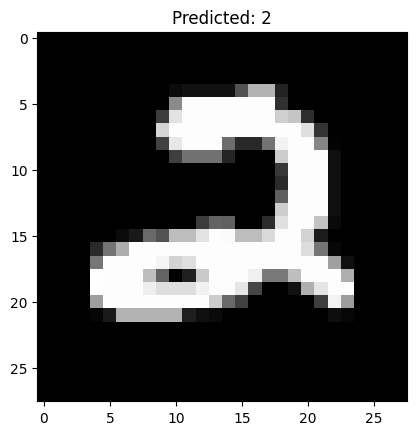

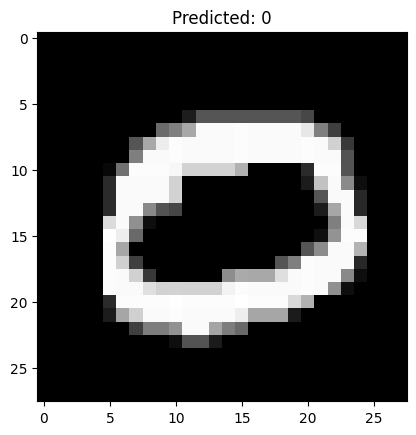

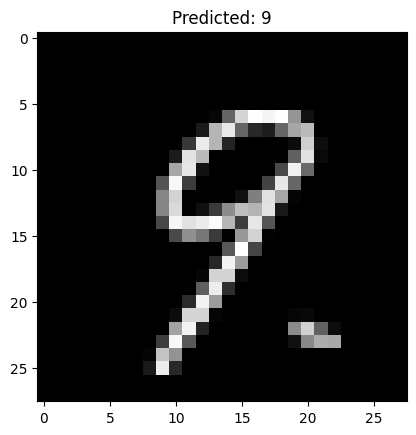

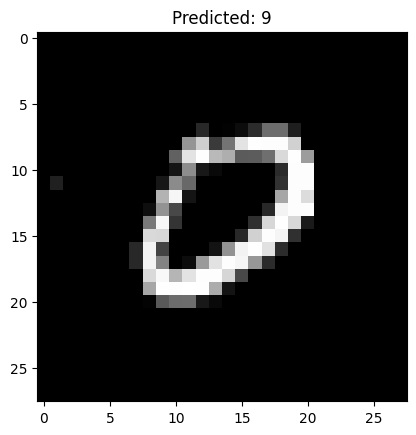

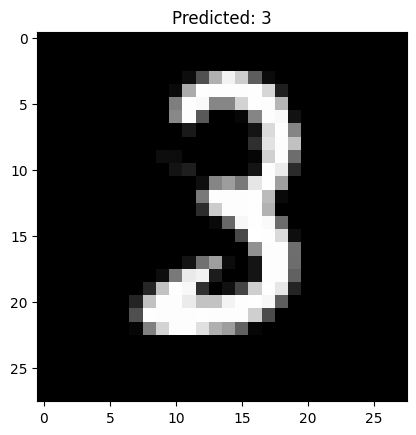

In [13]:
def test_sample(model, test_loader):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        for i in range(5):  # Display 5 predictions
            image = test_images[i].unsqueeze(0)  # Add batch dimension
            output = model(image)
            predicted_label = torch.argmax(output, dim=1).item()
            
            plt.imshow(image.squeeze().numpy(), cmap="gray")
            plt.title(f"Predicted: {predicted_label}")
            plt.show()

test_sample(model, test_images)

#Explanations:
#model.eval() → Switch to evaluation mode.
#torch.no_grad() → Avoid unnecessary calculations.
#Pick 5 test images, run through the model, and show predictions.